In [1]:
import numpy as np
from scipy.linalg import lstsq, norm, eig, pinv
from scipy.sparse.linalg import lsqr
from scipy.sparse import spdiags, eye
import matplotlib.pyplot as plt

In [2]:
def first_diffs_2d_matrix(m,n):
# % Construct circulant first differences matrix
    Im, In = (np.eye(m), np.eye(n))
    
    Dm = -Im + np.roll(Im,1,axis=1)
    Dn = -In + np.roll(In,1,axis=0)   

    A = np.vstack((np.kron(Dn, Im),   #  % First differences across rows
                   np.kron(In, Dm)))     #  % First differences down columns
    
    return A

In [3]:
# Finite difference method
# problem size
m, n = (30, 20)
cols, rows = np.meshgrid(np.arange(n),np.arange(m))

# disk parameters
cx = 8
cy = 20
r = 5

# create matrix with disk
X = (rows-cy)**2 + (cols-cx)**2 <= r**2

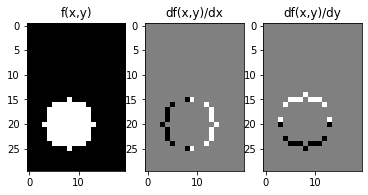

In [6]:
plt.figure()
plt.subplot(131)
plt.imshow(X, cmap='gray')
plt.title('f(x,y)')


# test your first diffs matrix
A = first_diffs_2d_matrix(m,n)

x = X.flatten('F').astype(int)
DFDX = A[:m*n,:] @ x
DFDY = A[m*n:2*m*n,:] @ x

plt.subplot(132)
plt.imshow(np.reshape(DFDX, (m,n), order='F'), cmap='gray')
plt.title('df(x,y)/dx')

plt.subplot(133)
plt.imshow(np.reshape(DFDY, (m,n), order='F'), cmap='gray')
plt.title('df(x,y)/dy');

In [3]:
def compute_normals(I,L):        
# % Inputs:       I is an (m x n x d) matrix whose d slices contain m x n
# %               double-precision images of a common scene under different
# %               lighting conditions
# %               
# %               L is a (3 x d) matrix such that L(:,i) is the lighting
# %               direction vector for image I(:,:,i)
# %               
# % Outputs:      N is an (m x n x 3) matrix containing the unit-norm surface
# %               normal vectors for each pixel in the scene

    m, n, d = I.shape

    I_reshaped = I.reshape(m*n, d)
    I_reshaped = I_reshaped.T
    
    N = np.zeros((L.shape[0],m*n))

    for ii in range(m*n):
        p = lstsq(L.T,I_reshaped[:,ii])[0]
        N[:,ii] = p/norm(p)

    N = N.T
    N = N.reshape(m, n, 3) 

    return N

/Users/pmw/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


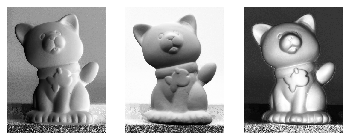

In [4]:
from scipy.io import loadmat
# load data
# I = images   (m x n x d)
# L = lighting (3 x d) 
# M = mask     (m x n)
catData = loadmat('cat.mat')
I = catData['I']
L = catData['L']
M = catData['M']

m, n, d = I.shape

N = compute_normals(I, L)
np.seterr(true_divide='ignore')

plt.figure()
plt.subplot(131)
plt.imshow(N[:,:,0], cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(N[:,:,1], cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(N[:,:,2], cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
# Compute gradients from normals
#
# NOTE: There's no "-" in the definition of DFDY because row indexing of
#       matrices in MATLAB is reversed (row 1 = top) and so the sign must
#       be flipped in order for the y-gradients to be oriented correctly

DFDX = -N[:,:,0] / N[:,:,2]       
DFDY =  N[:,:,1] / N[:,:,2]
DFDX[np.isnan(DFDX)] = 0         # Clean data
DFDX[M==0] = 0                   # Apply mask
DFDY[np.isnan(DFDY)] = 0         # Clean data
DFDY[M==0] = 0                   # Apply mask


# Construct least-squares problem from gradients
A = first_diffs_2d_matrix(m,n)
b = np.vstack((DFDX,DFDY))                     

In [ ]:
# Built-in solver
fxy = lsqr(A, b, iter_lim=100)[0]

# Format surface
FXY = np.reshape(fxy, [m,n], order='F')         # Reshape into matrix
FXY = FXY - np.amin(FXY[M])            # Anchor to z-axis
FXY = FXY * M                     # Apply mask

fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(DFDX, cmap='gray')
axes[0, 0].axis('off')
axes[0, 1].imshow(DFDY, cmap='gray')
axes[0, 1].axis('off')
axes[1, 0].imshow(FXY, cmap='gray')
axes[1, 0].axis('off')

# Set up surface plot axes
X = np.arange(n)
Y = np.arange(m)
X, Y = np.meshgrid(X, Y)

# Plots
fig = plt.figure()
ax = fig.add_subplot(2, 2, 1)
ax.imshow(DFDX, cmap='gray')
ax.axis('off')
ax = fig.add_subplot(2, 2, 2)
ax.imshow(DFDY, cmap='gray')
ax.axis('off')
ax = fig.add_subplot(2, 2, 3)
ax.imshow(FXY, cmap='gray')
ax.axis('off')
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.plot_surface(X, Y, FXY, linewidth=0, antialiased=False, cmap='gray')
